In [1]:
from __future__ import print_function
import numpy as np
from scipy.io import loadmat
import os
import glob
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


Create Datasets by randomly mixing 10min segments of preictal and interictal data.

In [3]:
#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files):
    print('Reading files ' + files[0] + ' to ' + files[-1])
    nrfiles = len(files)
    placeholder_data = np.ndarray(shape=(nrfiles, 400*10*60, 16), dtype=np.float32)
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        placeholder_data[idx, :, :] = ndata['data']
    
    return placeholder_data

nrOfFiles = 30

def create_dataset(folder, name_pickle):
    #get files
    files_preictal = glob.glob(folder + "/*1.mat")
    files_interictal = glob.glob(folder + "/*0.mat")
    #randomize read files
    np.random.shuffle(files_preictal)
    np.random.shuffle(files_interictal)
    #read files into ndarrays
    data_preictal = mat_to_numpy(files_preictal[:nrOfFiles])
    labels_preictal = np.ones(data_preictal.shape[0], dtype=np.int32)
    data_interictal = mat_to_numpy(files_interictal[:nrOfFiles])
    labels_interictal = np.zeros(data_interictal.shape[0], dtype=np.int32)
    #concatenate preictal and interictal data
    data_merge = np.concatenate((data_preictal, data_interictal), axis=0)
    labels_merge = np.concatenate((labels_preictal, labels_interictal), axis=0)
    #shuffle data and labels mantaining relation between them
    shuffle_idx = np.random.permutation(data_merge.shape[0])
    data_merge = data_merge[shuffle_idx,:,:]
    labels_merge = labels_merge[shuffle_idx]
    #budle data and labels in dictionary
    save = {'data': data_merge, 'labels': labels_merge}
    try:
        with open(name_pickle, 'wb') as f:
            print('Pickling to ' + name_pickle)
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to' + name_pickle + ' :', e)
    
create_dataset('./train_1', 'trainsh2.pickle')

print('dataset done')

Reading files ./train_1/1_25_1.mat to ./train_1/1_35_1.mat
Reading files ./train_1/1_409_0.mat to ./train_1/1_360_0.mat
Pickling to trainsh2.pickle
dataset done


Load pickled dataset into memory.

In [3]:
name_pickle = 'trainsh1.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('Data loaded: shape', dataset.shape)

Unpickling trainsh1.pickle
Data loaded: shape (80, 240000, 16)


Plot some data to have an idea of how it looks like

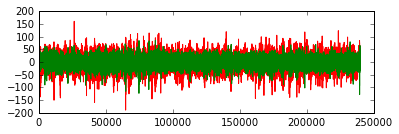

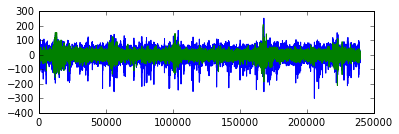

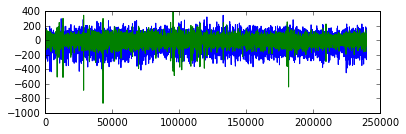

In [5]:
plt.subplot(211)
plt.plot(dataset[0,:,0], 'r')
plt.plot(dataset[0,:,8], 'g')

plt.figure(2)
plt.subplot(211)
plt.plot(dataset[23,:,0])
plt.plot(dataset[23,:,8])

plt.figure(3)
plt.subplot(211)
plt.plot(dataset[57,:,9])
plt.plot(dataset[57,:,5])

EEGNET implementation

Ideas
  - Condition classification based on sensor?

In [2]:
# Create a convolution filter variable with the specified name and shape,
# and initialize it using xavier initialization.
def create_variable(name, shape):
    #    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    #    variable = tf.get_variable(name, shape=shape, initializer=initializer)
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    variable = tf.Variable(initializer(shape=shape), name=name)
    return variable


# Create a bias variable with the specified name and shape and initialize
# it to zero.
def create_bias_variable(name, shape):
    initializer = tf.constant_initializer(value=0.0, dtype=tf.float32)
    return tf.Variable(initializer(shape=shape), name)


def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])


def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])


def causal_conv(value, filter_, dilation, name='causal_conv'):
    with tf.name_scope(name):
        # Pad beforehand to preserve causality.
        filter_width = tf.shape(filter_)[0]
        padding = [[0, 0], [(filter_width - 1) * dilation, 0], [0, 0]]
        padded = tf.pad(value, padding)
        if dilation > 1:
            transformed = time_to_batch(padded, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1, padding='SAME')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(padded, filter_, stride=1, padding='SAME')
        # Remove excess elements at the end.
        result = tf.slice(restored,
                          [0, 0, 0],
                          [-1, tf.shape(value)[1], -1])
        return result


def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = quantization_channels - 1
        # Perform mu-law companding transformation (ITU-T, 1988).
        magnitude = tf.log(1 + mu * tf.abs(audio)) / tf.log(1. + mu)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.cast((signal + 1) / 2 * mu + 0.5, tf.int32)


def mu_law_decode(output, quantization_channels):
    '''Recovers waveform from quantized values.'''
    with tf.name_scope('decode'):
        mu = quantization_channels - 1
        # Map values back to [-1, 1].
        casted = tf.cast(output, tf.float32)
        signal = 2 * (casted / mu) - 1
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**abs(signal) - 1)
    return tf.sign(signal) * magnitude


class WaveNet(object):
    '''Implements the WaveNet network for generative audio.
    Usage (with the architecture as in the DeepMind paper):
        dilations = [2**i for i in range(N)] * M
        filter_width = 2  # Convolutions just use 2 samples.
        residual_channels = 16  # Not specified in the paper.
        dilation_channels = 32  # Not specified in the paper.
        net = WaveNet(batch_size, dilations, filter_width,
                      residual_channels, dilation_channel)
        loss = net.loss(input_batch)
    '''

    def __init__(self,
                 batch_size,
                 dilations,
                 filter_width,
                 residual_channels,
                 dilation_channels,
                 skip_channels,
                 quantization_channels=2**8,
                 use_biases=False,
                 fast_generation=False):
        '''Initializes the WaveNet model.
        Args:
            batch_size: How many audio files are supplied per batch
                (recommended: 1).
            dilations: A list with the dilation factor for each layer.
            filter_width: The samples that are included in each convolution,
                after dilating.
            residual_channels: How many filters to learn for the residual.
            dilation_channels: How many filters to learn for the dilated
                convolution.
            skip_channels: How many filters to learn that contribute to the
                quantized softmax output.
            quantization_channels: How many amplitude values to use for audio
                quantization and the corresponding one-hot encoding.
                Default: 256 (8-bit quantization).
            use_biases: Whether to add a bias layer to each convolution.
                Default: False.
            fast_generation: Whether to use the fast generation architecture.
                Default: False.
        '''
        self.batch_size = batch_size
        self.dilations = dilations
        self.filter_width = filter_width
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.quantization_channels = quantization_channels
        self.use_biases = use_biases
        self.skip_channels = skip_channels
        self.fast_generation = fast_generation

        if self.fast_generation and self.use_biases:
            raise NotImplementedError(
                'Biases not implemented for fast generation.')

    def _create_causal_layer(self, input_batch, in_channels, out_channels):
        '''Creates a single causal convolution layer.
        The layer can change the number of channels.
        '''
        with tf.name_scope('causal_layer'):
            weights_filter = create_variable("filter", [self.filter_width,
                                                        in_channels,
                                                        out_channels])
            return causal_conv(input_batch, weights_filter, 1)

    def _create_dilation_layer(self, input_batch, layer_index, dilation,
                               in_channels, dilation_channels, skip_channels):
        '''Creates a single causal dilated convolution layer.
        The layer contains a gated filter that connects to dense output
        and to a skip connection:
               |-> [gate]   -|        |-> 1x1 conv -> skip output
               |             |-> (*) -| 
        input -|-> [filter] -|        |-> 1x1 conv -|
               |                                    |-> (+) -> dense output
               |------------------------------------|
        Where `[gate]` and `[filter]` are causal convolutions with a
        non-linear activation at the output.
        '''
        weights_filter = create_variable("filter", [self.filter_width,
                                                    in_channels,
                                                    dilation_channels])
        weights_gate = create_variable("gate", [self.filter_width,
                                                in_channels,
                                                dilation_channels])

        conv_filter = causal_conv(input_batch, weights_filter, dilation)
        conv_gate = causal_conv(input_batch, weights_gate, dilation)

        if self.use_biases:
            biases_filter = create_bias_variable("filter_biases",
                                                 [dilation_channels])
            biases_gate = create_bias_variable("filter_biases",
                                               [dilation_channels])
            conv_filter = tf.add(conv_filter, biases_filter)
            conv_gate = tf.add(conv_gate, biases_gate)

        out = tf.tanh(conv_filter) * tf.sigmoid(conv_gate)

        # The 1x1 conv to produce the dense contribution.
        weights_dense = create_variable("dense", [1, dilation_channels,
                                                     in_channels])
        transformed = tf.nn.conv1d(
            out, weights_dense, stride=1, padding="SAME", name="dense")

        # The 1x1 conv to produce the skip contribution.
        weights_skip = create_variable("skip", [1, dilation_channels,
                                                skip_channels])
        skip_contribution = tf.nn.conv1d(
            out, weights_skip, stride=1, padding="SAME", name="skip")

        if self.use_biases:
            biases_dense = create_bias_variable("dense_biases", [in_channels])
            transformed = tf.add(transformed, biases_dense)
            biases_skip = create_bias_variable("skip_biases", [skip_channels])
            skip_contribution = tf.add(skip_contribution, biases_skip)

        layer = 'layer{}'.format(layer_index)
        tf.histogram_summary(layer + '_filter', weights_filter)
        tf.histogram_summary(layer + '_gate', weights_gate)
        tf.histogram_summary(layer + '_dense', weights_dense)
        tf.histogram_summary(layer + '_skip', weights_skip)
        if self.use_biases:
            tf.histogram_summary(layer + '_biases_filter', biases_filter)
            tf.histogram_summary(layer + '_biases_gate', biases_gate)
            tf.histogram_summary(layer + '_biases_dense', biases_dense)
            tf.histogram_summary(layer + '_biases_skip', biases_skip)

        return skip_contribution, input_batch + transformed

    def _apply_weights(self, input_batch, state_batch, weights):
        weights_recurrent = weights[0, :, :]
        weights_embedding = weights[1, :, :]

        output = (tf.matmul(input_batch, weights_embedding) + tf.matmul(
            state_batch, weights_recurrent))
        return output

    def _generator_causal_layer(self, input_batch, state_batch, in_channels,
                                out_channels):
        with tf.name_scope('causal_layer'):
            weights_filter = tf.Variable(
                tf.truncated_normal(
                    [self.filter_width, in_channels, out_channels],
                    stddev=0.2,
                    name="filter"))

            output = self._apply_weights(input_batch, state_batch,
                                         weights_filter)
        return output

    def _generator_dilation_layer(self, input_batch, state_batch, layer_index,
                                  dilation, in_channels, dilation_channels,
                                  skip_channels):
        weights_filter = tf.Variable(
            tf.truncated_normal(
                [self.filter_width, in_channels, dilation_channels],
                stddev=0.2,
                name="filter"))
        weights_gate = tf.Variable(
            tf.truncated_normal(
                [self.filter_width, in_channels, dilation_channels],
                stddev=0.2,
                name="gate"))

        output_filter = self._apply_weights(input_batch, state_batch,
                                            weights_filter)
        output_gate = self._apply_weights(input_batch, state_batch,
                                          weights_gate)

        out = tf.tanh(output_filter) * tf.sigmoid(output_gate)

        weights_dense = tf.Variable(
            tf.truncated_normal(
                [1, dilation_channels, in_channels], stddev=0.2, name="dense"))
        transformed = tf.matmul(out, weights_dense[0, :, :])

        weights_skip = tf.Variable(
            tf.truncated_normal(
                [1, dilation_channels, skip_channels], stddev=0.1),
                name="skip")
        skip_contribution = tf.matmul(out, weights_skip[0, :, :])

        layer = 'layer{}'.format(layer_index)

        return skip_contribution, input_batch + transformed

    def _create_network(self, input_batch):
        '''Creates a WaveNet network.'''
        outputs = []
        current_layer = input_batch

        # Pre-process the input with a regular convolution
        current_layer = self._create_causal_layer(
            current_layer, self.quantization_channels, self.residual_channels)

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = self._create_dilation_layer(
                        current_layer, layer_index, dilation,
                        self.residual_channels, self.dilation_channels,
                        self.skip_channels)
                    outputs.append(output)

        with tf.name_scope('postprocessing'):
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
            w1 = create_variable("postprocess1", [1, self.skip_channels,
                                                  self.skip_channels])
            w2 = create_variable("postprocess2", [1, self.skip_channels,
                                                  self.quantization_channels])
            if self.use_biases:
                b1 = create_bias_variable("postprocess1_bias",
                                          [self.skip_channels])
                b2 = create_bias_variable("postprocess2_bias",
                                          [self.quantization_channels])

            tf.histogram_summary('postprocess1_weights', w1)
            tf.histogram_summary('postprocess2_weights', w2)
            if self.use_biases:
                tf.histogram_summary('postprocess1_biases', b1)
                tf.histogram_summary('postprocess2_biases', b2)

            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)
            transformed1 = tf.nn.relu(total)
            conv1 = tf.nn.conv1d(transformed1, w1, stride=1, padding="SAME")
            if self.use_biases:
                conv1 = tf.add(conv1, b1)
            transformed2 = tf.nn.relu(conv1)
            conv2 = tf.nn.conv1d(transformed2, w2, stride=1, padding="SAME")
            if self.use_biases:
                conv2 = tf.add(conv2, b2)

        return conv2

    def _create_generator(self, input_batch):
        init_ops = []
        push_ops = []
        outputs = []
        current_layer = input_batch

        q = tf.FIFOQueue(
            1,
            dtypes=tf.float32,
            shapes=(self.batch_size, self.quantization_channels))
        init = q.enqueue_many(
            tf.zeros((1, self.batch_size, self.quantization_channels)))

        current_state = q.dequeue()
        push = q.enqueue([current_layer])
        init_ops.append(init)
        push_ops.append(push)

        current_layer = self._generator_causal_layer(
            current_layer, current_state, self.quantization_channels,
            self.residual_channels)

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):

                    q = tf.FIFOQueue(
                        dilation,
                        dtypes=tf.float32,
                        shapes=(self.batch_size, self.residual_channels))
                    init = q.enqueue_many(
                        tf.zeros((dilation, self.batch_size,
                                  self.residual_channels)))

                    current_state = q.dequeue()
                    push = q.enqueue([current_layer])
                    init_ops.append(init)
                    push_ops.append(push)

                    output, current_layer = self._generator_dilation_layer(
                        current_layer, current_state, layer_index, dilation,
                        self.residual_channels, self.dilation_channels,
                        self.skip_channels)
                    outputs.append(output)
        self.init_ops = init_ops
        self.push_ops = push_ops

        with tf.name_scope('postprocessing'):
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
            w1 = tf.Variable(
                tf.truncated_normal(
                    [1, self.skip_channels, self.skip_channels],
                    stddev=0.3,
                    name="postprocess1"))
            w2 = tf.Variable(
                tf.truncated_normal(
                    [1, self.skip_channels, self.quantization_channels],
                    stddev=0.3,
                    name="postprocess2"))
 
            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)
            transformed1 = tf.nn.relu(total)

            conv1 = tf.matmul(transformed1, w1[0, :, :])
            transformed2 = tf.nn.relu(conv1)
            conv2 = tf.matmul(transformed2, w2[0, :, :])

        return conv2

    def _one_hot(self, input_batch):
        '''One-hot encodes the waveform amplitudes.
        This allows the definition of the network as a categorical distribution
        over a finite set of possible amplitudes.
        '''
        with tf.name_scope('one_hot_encode'):
            encoded = tf.one_hot(
                input_batch,
                depth=self.quantization_channels,
                dtype=tf.float32)
            if self.fast_generation:
                shape = [self.batch_size, self.quantization_channels]
            else:
                shape = [self.batch_size, -1, self.quantization_channels]
            encoded = tf.reshape(encoded, shape)
        return encoded

    def predict_proba(self, waveform, name='wavenet'):
        '''Computes the probability distribution of the next sample.'''
        with tf.name_scope(name):
            encoded = self._one_hot(waveform)
            if self.fast_generation:
                if self.use_biases:
                    raise RuntimeError("Fast generation does not support" \
                                       " biases.")
                raw_output = self._create_generator(encoded)
            else:
                raw_output = self._create_network(encoded)
            out = tf.reshape(raw_output, [-1, self.quantization_channels])
            proba = tf.nn.softmax(tf.cast(out, tf.float64))
            last = tf.slice(proba, [tf.shape(proba)[0] - 1, 0],
                            [1, self.quantization_channels])
            return tf.reshape(last, [-1])

    def loss(self, input_batch, name='wavenet'):
        '''Creates a WaveNet network and returns the autoencoding loss.
        The variables are all scoped to the given name.
        '''
        with tf.name_scope(name):
            input_batch = mu_law_encode(input_batch,
                                        self.quantization_channels)
            encoded = self._one_hot(input_batch)
            raw_output = self._create_network(encoded)

            with tf.name_scope('loss'):
                # Shift original input left by one sample, which means that
                # each output sample has to predict the next input sample.
                shifted = tf.slice(encoded, [0, 1, 0],
                                   [-1, tf.shape(encoded)[1] - 1, -1])
                shifted = tf.pad(shifted, [[0, 0], [0, 1], [0, 0]])

                prediction = tf.reshape(raw_output,
                                        [-1, self.quantization_channels])
                loss = tf.nn.softmax_cross_entropy_with_logits(
                    prediction,
                    tf.reshape(shifted, [-1, self.quantization_channels]))
                reduced_loss = tf.reduce_mean(loss)

                tf.scalar_summary('loss', reduced_loss)

        return reduced_loss

net = WaveNet(
        batch_size=1,
        dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 256],
        filter_width=2,
        residual_channels=32,
        dilation_channels=16,
        skip_channels=256,
        quantization_channels=256,
        use_biases='false')

print('done')

done
